In [1]:
# Install required package
import sys
!{sys.executable} -m pip install --upgrade steam-nb-api

import os
from pathlib import Path
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from copy import *
from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

Defaulting to user installation because normal site-packages is not writeable


# Global variables

In [2]:
nameMagnet = 'd11T_1in1'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = True

# Generate magnet geometry parsing .data and .cadata files

roxie-HFM_v2_101104.cadata
d11T_1in1_All_WithIron_WithSelfField.data
VERSION 10.2.1
'DS-Dipole, FNAL Cable (40x0.70), no core, 56 Turns, 6 Blocks                       '
'roxie.bhdata                                                                       '
'roxie-HFM_v2_101104.cadata                                                         '
'Yoke_1in1_v7_111213.iron                                                           '

&OPTION
  LEND=F     LWEDG=F    LPERS=F    LQUENCH=F  LALGO=F    LQUENCH0D=F
  LMIRIRON=F LBEMFEM=T  LPSI=F     LSOLV=F    LIRON=T    LMORPH=F   
  LHARD=F    LPOSTP=F   LPEAK=T    LINMARG=F  LMARG=F    LSELF=T    
  LMQE=F     LINDU=F    LEDDY=F    LSOLE=F    LFLUX=F    LFIELD3=F  
  LFISTR=F   LSELF3=F   LBRICK=F   LLEAD=F    LVRML=F    LOPERA=F   
  LOPER20=F  LANSYS=F   LRX2ANS=F  LANS2RX=F  LDXF=F     LMAP2D=T   
  LMAP3D=F   LEXPR=F    LFIL3D=F   LFIL2D=F   LCNC=F     LANSYSCN=F 
  LWEIRON=F  LCATIA=F   LEXEL=T    LQVOLT=F   LAXIS=T    LIMAGX=T   
  LIMAGY=T 

<IPython.core.display.Javascript object>


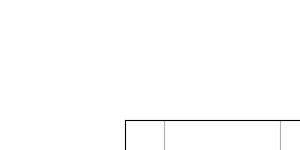

In [3]:
# Select ROXIE .cadata file with conductor data
fileNameCadata = 'roxie-HFM_v2_101104.cadata'
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'
print(fileNameCadata)
print(fileNameData)

# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)

# Plot conductors and their numbers
GeoArr = [[1,9],[1,8],[1,3],[1,2],[1,16],[1,18]]*4
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()


# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 8960
Peak magnetic field in the field-map from ROXIE = 11.717689530790617 T


<IPython.core.display.Javascript object>


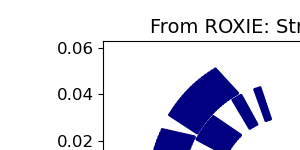

In [4]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
#         print(index)
#         print(row)
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()


# Manipulate imported strand positions

In [5]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

Total number of strands = 8960
Total number of half-turns = 224
Total number of turns = 112
Total number of groups = 24


<IPython.core.display.Javascript object>

# Overall magnet variables

In [6]:
T00 = 1.9
l_magnet = 1.70
I00 = 11850
Iref = 11850

# Definition of groups of conductors

1 coil sections defined.
24 groups defined.


<IPython.core.display.Javascript object>


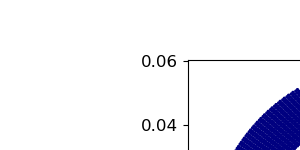

(-0.06665652829297011,
 0.06665652829297011,
 -0.05676358912626073,
 0.05676358912626073)

In [7]:
GroupToCoilSection = nGroups * [1]
polarities_inGroup = ( 6 * [+1] + 6 * [-1] ) + ( 6 * [-1] + 6 * [+1] )

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')


# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]
    
   

f = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Defined polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1,2,2)
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r')
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b')
    plt.gca().add_line(line)
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Expected polarities', **selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Conductor properties in each group

In [8]:
# Number of half-quadrants
nHalfQuadrants = 4

# Number of half-turns in each group
nT = nHalfQuadrants * [9, 8, 3, 2, 16, 18]
nHalfTurnsDefined = np.sum(nT)

# Number of strands in each cable belonging to a particular group
nStrands_inGroup = nGroupsDefined * [40]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = nGroupsDefined * [l_magnet]
# strand diameter [m]
ds_inGroup = nGroupsDefined * [0.70E-3]
# filament diameter [m]
df_inGroup = nGroupsDefined * [41E-6]
# fraction of superconductor in the strands
f_SC_strand_inGroup = nGroupsDefined * [1/(1+1.19)]
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = nGroupsDefined * [1]
# Filament twist-pitch [m]
Lp_f_inGroup = nGroupsDefined * [0.014]
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = nGroupsDefined * [159]
# type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = nGroupsDefined * [2]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = nGroupsDefined * [1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = nGroupsDefined * [1]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = nGroupsDefined * [1]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = nGroupsDefined * [1]
# bare cable width [m]
wBare_inGroup = nGroupsDefined * [14.847E-3]
# bare average cable height [m]
hBare_inGroup = nGroupsDefined * [1.3065E-3]
# insulation thickness in the width direction [m]
wIns_inGroup = nGroupsDefined * [100E-6]
# insulation thickness in the height direction [m]
hIns_inGroup = nGroupsDefined * [100E-6]
# Strand twist-pitch [m]
Lp_s_inGroup = nGroupsDefined * [0.111]
# Cross-contact resistance [Ohm]
R_c_inGroup = nGroupsDefined * [10E-6]
# Tc0_NbTi_ht_inGroup - ONLY USED FOR NB-TI [K]
Tc0_NbTi_ht_inGroup = nGroupsDefined * [0]
# Bc2_NbTi_ht_inGroup - ONLY USED FOR NB-TI  [T]
Bc2_NbTi_ht_inGroup = nGroupsDefined * [0]
# c1_Ic_NbTi_inGroup - ONLY USED FOR NB-TI  [A]
c1_Ic_NbTi_inGroup = nGroupsDefined * [0]
# c2_Ic_NbTi_inGroup - ONLY USED FOR NB-TI  [A/T]
c2_Ic_NbTi_inGroup = nGroupsDefined * [0]
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = nGroupsDefined * [16.33]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = nGroupsDefined * [26.45]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = nGroupsDefined * [4.224E+10]

# # fitParameters_inGroup - Based on data from MB_mod_2d_iron10.2.1 - with magnetization calculation2
fitParameters_inGroup= np.array(nGroupsDefined * [[4.224E+10, 16.33, 26.45]]).transpose()
# Jc fit type (only used for persistent-current calculation): 1= Jc=constant; 2= Nb-Ti Bottura; 3= Nb-Ti CUDI ; 4= Nb3Sn Summer
selectedFit_inGroup= nGroupsDefined * [4]

print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
if nHalfTurnsDefined != nHalfTurns:
        raise Exception('Number of half-turns defined by nT ({}) is different from the number of half-turns in the magnetic field map ({}).'.format(nHalfTurnsDefined,nHalfTurns))
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 500E-6
insulationAroundCables = 100E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

224 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
0.28571428571428575


# Electrical order of the half-turns

The half-turns of these pairs of groups will be connected electrically:
[[5, 17], [6, 18], [4, 16], [3, 15], [2, 14], [1, 13], [23, 11], [24, 12], [22, 10], [21, 9], [20, 8], [19, 7]]


<IPython.core.display.Javascript object>


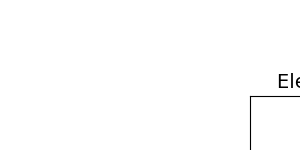

Calculated electrical order of the half-turns:
el_order_half_turns = [23, 135, 24, 136, 25, 137, 26, 138, 27, 139, 28, 140, 29, 141, 30, 142, 31, 143, 32, 144, 33, 145, 34, 146, 35, 147, 36, 148, 37, 149, 38, 150, 39, 151, 40, 152, 41, 153, 42, 154, 43, 155, 44, 156, 45, 157, 46, 158, 47, 159, 48, 160, 49, 161, 50, 162, 51, 163, 52, 164, 53, 165, 54, 166, 55, 167, 56, 168, 22, 134, 21, 133, 20, 132, 19, 131, 18, 130, 17, 129, 16, 128, 15, 127, 14, 126, 13, 125, 12, 124, 11, 123, 10, 122, 9, 121, 8, 120, 7, 119, 6, 118, 5, 117, 4, 116, 3, 115, 2, 114, 1, 113, 191, 79, 192, 80, 193, 81, 194, 82, 195, 83, 196, 84, 197, 85, 198, 86, 199, 87, 200, 88, 201, 89, 202, 90, 203, 91, 204, 92, 205, 93, 206, 94, 207, 95, 208, 96, 209, 97, 210, 98, 211, 99, 212, 100, 213, 101, 214, 102, 215, 103, 216, 104, 217, 105, 218, 106, 219, 107, 220, 108, 221, 109, 222, 110, 223, 111, 224, 112, 190, 78, 189, 77, 188, 76, 187, 75, 186, 74, 185, 73, 184, 72, 183, 71, 182, 70, 181, 69, 180, 68, 179, 67, 178, 66,

In [9]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether = [ [5,17], [6,18], [4,16], [3,15], [2,14], [1,13], [23,11], [24,12], [22,10], [21,9], [20,8], [19,7] ]
# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder = [ 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1 ]

nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)


# Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,0]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = {}'.format(el_order_half_turns))

# Cable geometry parameters

In [10]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG = [0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105 ]
# Rotate cable by a certain angle [deg]
rotation_block = \
int(nHalfTurnsDefined/4) * [  0] + \
int(nHalfTurnsDefined/4) * [180] + \
int(nHalfTurnsDefined/4) * [ 90] + \
int(nHalfTurnsDefined/4) * [270]
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = int(nHalfTurnsDefined/2) * [0] + int(nHalfTurnsDefined/2) * [1]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]


if len(alphasDEG)!=nHalfTurnsDefined:
    raise Exception('Length of the vector alphasDEG ({}) must be equal to nHalfTurnsDefined={}.'.format(len(alphasDEG),nHalfTurnsDefined))
if len(rotation_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector rotation_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(rotation_block),nHalfTurnsDefined))
if len(mirror_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirror_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirror_block),nHalfTurnsDefined))
if len(mirrorY_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirrorY_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirrorY_block),nHalfTurnsDefined))

# Heat exchange between half-turns along the cable wide side

In [11]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 186, 187, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223]
iConta

# Heat exchange between half-turns along the cable narrow side

Heat exchange along the cable narrow side - Calculated indices:
iContactAlongHeight_From = 
[1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 9, 10, 11, 12, 12, 13, 13, 14, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 23, 57, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 65, 66, 67, 68, 68, 69, 69, 70, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76, 79, 113, 113, 114, 114, 115, 115, 116, 116, 117, 117, 118, 118, 119, 119, 120, 121, 122, 123, 124, 124, 125, 125, 126, 126, 126, 127, 127, 128, 128, 129, 129, 130, 130, 131, 131, 132, 169, 169, 170, 170, 171, 171, 172, 172, 173, 173, 174, 174, 175, 175, 176, 177, 178, 179, 180, 180, 181, 181, 182, 182, 182, 183, 183, 184, 184, 185, 185, 186, 186, 187, 187, 188]
iContactAlongWidth_To = 
[24, 23, 169, 25, 24, 26, 25, 27, 26, 28, 27, 29, 30, 30, 31, 32, 33, 38, 39, 40, 39, 41, 40, 42, 41, 43, 43, 44, 44, 45, 46, 45, 55, 54, 55, 56, 56, 191, 113, 79, 80, 81, 80, 82, 81, 83, 82, 83, 84, 85, 86, 86, 87, 88, 89, 94, 95, 95,

<IPython.core.display.Javascript object>


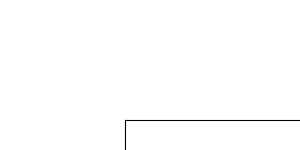

(-0.06665652829297011,
 0.06665652829297011,
 -0.05676358912626073,
 0.05676358912626073)

In [12]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = 1.7E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])

# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
print(iContactAlongHeight_To)


# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=2, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Quench initiation calculation: Force selected half-turns to quench

In [13]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = [1]
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
vQ_iStartQuench = [9999]

# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>

# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [14]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 0.0005
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.0001
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.700

# Power supply control

<IPython.core.display.Javascript object>


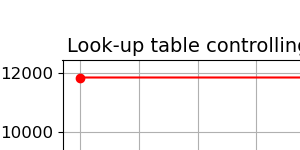

In [15]:
# Time when the power supply is switched off and the crowbar is switched on [s]
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [-0.02, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.figure(figsize=(5,5))
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Energy-extraction system

In [16]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.066

# CLIQ system

In [17]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# Quench heater parameters

In [18]:
# Number of quench heater strips to write in the file
nHeaterStripsType1 = 4
nHeaterStripsType2 = 4

# Time at which the power supply connected to the QH strip is triggered (set to a very large value to avoid triggering).
tQH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [.001, .001]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [450, 450]
# Capacitance of the capacitor connected to the QH strip.
C_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [14.1E-3, 14.1E-3]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [2.344, 2.596]
# Width of the non-Cu-plated part of the the QH strip.
w_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [19E-3, 24E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [25E-6, 25E-6]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [55E-6, 55E-6]
# Type of material of the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [2, 2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [508E-6, 508E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [2, 2]
# Length of the QH strip
l_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [l_magnet, l_magnet]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [0.3571, 0.2778]

# Heat exchange between quench heater strips and half-turns - QH POSITIONS ONLY GUESSED

<IPython.core.display.Javascript object>


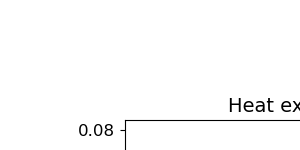

iQH_toHalfTurn_From = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
iQH_toHalfTurn_To = [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221]


In [19]:
# Thermal connections between heater strips and half-turns are manually defined for one half-quadrant and then automatically extended to the other half-quadrants
iQH_toHalfTurn_From_oneHalfQuadrant = 12*[1] + 12*[2]
iQH_toHalfTurn_To_oneHalfQuadrant = list(range(27,38+1)) + list(range(42,53+1))

nHalfTurnsinHQ = sum(nT[0:6])
nQHStripsInHQ = 2


# Automatically extend to the other half-quadrants
iQH_toHalfTurn_To=[]
iQH_toHalfTurn_From=[]
for i in range (0,nHalfQuadrants):
    iQH_tempVector_To = list(np.asarray(iQH_toHalfTurn_To_oneHalfQuadrant) + i*nHalfTurnsinHQ)
    iQH_toHalfTurn_To.extend(iQH_tempVector_To)
    
    iQH_tempVector_From = list(np.asarray(iQH_toHalfTurn_From_oneHalfQuadrant) + i*nQHStripsInHQ)
    iQH_toHalfTurn_From.extend(iQH_tempVector_From)
    
# Plot
iQH_toHalfTurn_From_Array = np.int_(iQH_toHalfTurn_From)
iQH_toHalfTurn_To_Array = np.int_(iQH_toHalfTurn_To)

f = plt.figure(figsize=(10,10))
plt.scatter(x, y,s=1, c='k')
plt.scatter(x_ave[iQH_toHalfTurn_To_Array-1], y_ave[iQH_toHalfTurn_To_Array-1], s=10, c=iQH_toHalfTurn_From_Array)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange between half-turns and QH',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('QH strip number [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


print ('iQH_toHalfTurn_From = {}'.format(iQH_toHalfTurn_From))
print ('iQH_toHalfTurn_To = {}'.format(iQH_toHalfTurn_To))

# Adiabatic hot-spot temperature calculation

In [20]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [-0.015]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [21]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]


# Define self-mutual inductance calculation object
coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

# Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = M_coilSections_calculated
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.005378538900984386 H/m


<IPython.core.display.Javascript object>


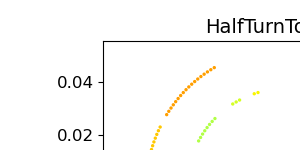

In [22]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Calculation of capacitance

In [23]:
magnet_center = np.array([0,0]) # x,y in mm
flag_CapacitanceToBore = 1
flag_CapacitanceToCollar = 1 
epsR_CabIns = 3.4 #Guess Value G10
epsR_LayerToBore = 3.4 #Guess Value G10
epsR_LayerToCollar = 3.4#Guess Value G10
hIns_InnerLayerToBore = 0.0005 # Guess Value
hIns_OuterLayerToCollar = 0.0005 #Guess Value
LayerPattern_Quadrant = [4,2] #Define number of Groups per Layer in one Quadrant/Sextant (Outer first)

# Capacitance between inner turns and bore
#1. Find turns that are inner layer + outer layer
eps0 = 1/(4*np.pi*1E-7*299792458**2)
Turns_InnerBore = np.array([])
Turns_OuterCollar = np.array([])
ProximityCable = np.zeros((nHalfTurnsDefined,1))
LayerCount = 1
GroupCount = 1
for j in range(nHalfTurnsDefined):
    ProximityCable[j] = np.sqrt((magnet_center[0]/1000-x_ave[j])**2 + (magnet_center[1]/1000-y_ave[j])**2)
CondCount = 0
for i in range(len(GeoArr)):
    CabSnippet = ProximityCable[CondCount:CondCount+GeoArr[i][0]*GeoArr[i][1]] 
    if LayerCount == 1:
        Turns_InnerBore = np.concatenate((Turns_InnerBore, CondCount + np.argsort(CabSnippet[:,0])[:GeoArr[i][1]]))
    if LayerCount ==len(LayerPattern_Quadrant):
        Turns_OuterCollar = np.concatenate((Turns_OuterCollar, CondCount + np.argsort(CabSnippet[:,0])[GeoArr[i][0]*GeoArr[i][1]-GeoArr[i][1]:]))
    CondCount = CondCount + GeoArr[i][0]*GeoArr[i][1]
    GroupCount = GroupCount +1
    if GroupCount>LayerPattern_Quadrant[LayerCount -1]:
        GroupCount =1
        LayerCount = LayerCount +1
        if LayerCount > len(LayerPattern_Quadrant):
            LayerCount =1
Turns_InnerBore = Turns_InnerBore.astype(int)
Turns_OuterCollar = Turns_OuterCollar.astype(int)
    
#2. Calculate Capacitances
Capacity_Inner_Bore = 0
if flag_CapacitanceToBore:
    for i in range(len(Turns_InnerBore)):
        Capacity_Inner_Bore = Capacity_Inner_Bore + 1/(1/(eps0 * epsR_CabIns * ((l_mag_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]*(hBare_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]+2*wIns_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]))\
                                                                          /hIns_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1])) \
                                                   + 1/(eps0 * epsR_LayerToBore * ((l_mag_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]*(hBare_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]+2*wIns_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1])) \
                                                                                /hIns_InnerLayerToBore)))     
    print("Capacity of Turns to Bore: ", Capacity_Inner_Bore*1E9, "nF") 
Capacity_Collar = 0
Sum = 0
if flag_CapacitanceToCollar:
    for i in range(len(Turns_OuterCollar)):
        Capacity_Collar = Capacity_Collar + 1/(1/(eps0 * epsR_CabIns * ((l_mag_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]*(hBare_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]+2*wIns_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1])) \
                                                                  /hIns_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1])) \
                                               + 1/(eps0 * epsR_LayerToCollar * ((l_mag_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]*(hBare_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]+2*wIns_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1])) \
                                                                                /hIns_OuterLayerToCollar)))
    print("Capacity of Turns to Collar: ", Capacity_Collar*1E9, "nF") 
print("Total parasitic capacitance:", (Capacity_Collar+Capacity_Inner_Bore)*1E9, "nF") 

Capacity of Turns to Bore:  11.307774164877934 nF
Capacity of Turns to Collar:  17.47565098208407 nF
Total parasitic capacitance: 28.783425146962003 nF


# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE

In [24]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [11.85, 1196.3, 2380.7, 3565.1, 4749.5, 5933.9, 7118.3, 8302.7, 9487.1, 10672, 11856, 13040, 14225, 15409, 16594, 17778, 18962, 20147, 21331, 22516, 23700, ]
# Values of fL_L higher than 1.53 are ignored and substituted with 1.41343502796317
fL_L = [1.22027003635105, 1.2171542323005, 1.2171542323005, 1.21706768218799, 1.21516357971265, 1.20157521204778, 1.17379262593041, 1.13449887484854, 1.09139691881599, 1.05089146615891, 1.03037908949282, 1.02077202700364, 1.01445386879003, 1.00978016271421, 1.00649125843864, 1.00441405573827, 1.00302925393803, 1.00207720270036, 1.00129825168773, 1.00060585078761, 1, ]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>

# Time Vector Definition

<IPython.core.display.Javascript object>


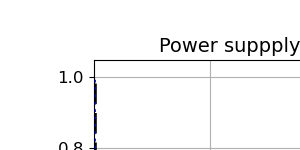

In [25]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [-0.02, 2.50E-05, -0.001, -0.000975, 2.50E-05, 0.05, 0.0505, 5.00E-04, 1]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

# Options - Change something only if you know what you're doing

In [26]:
# Field-Map Files Options
Iref = Iref
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 2
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 2
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 1
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.005
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 1
MinMaxXY_MTF = [-70, 70, -70, 70]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [27]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [28]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH','T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [29]:
# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()

# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
    RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH, s_ins_QH, type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m
)

# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)

# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)

# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)

# Visualize the defined variables

In [30]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

### "Inputs" variables ###
Initial temperature [K]
T00 1.9
Magnetic length [m]
l_magnet 1.7
Initial current [A]
I00 11850
Define the coil section where each group of cables is located
GroupToCoilSection [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Polarity of the current in each group of strands
polarities_inGroup [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
Number of half-turns in each group
nT [9, 8, 3, 2, 16, 18, 9, 8, 3, 2, 16, 18, 9, 8, 3, 2, 16, 18, 9, 8, 3, 2, 16, 18]
Number of strands in each cable belonging to a particular group
nStrands_inGroup [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
length of each half turn [m] (default=l_magnet)
l_mag_inGroup [1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7]
strand diameter [m]
ds_inGroup [0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0

# Write the LEDET input file

In [31]:
nameFileLEDET = nameMagnet + '_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

Preliminary consistency check was successful! -  d11T_1in1_0.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-26 15:32:51.001765
New file d11T_1in1_0.xlsx generated.


# Persistent Currents 

In [32]:
# This cell writes an input file for simulating a powering cycle

# Define input parameters 
I00 =  11850   # Amplitude of powering current Ia. Default: nominal current  
I_PC_LUT = [0, 0, I00, I00, 0, 0, I00, I00, 0]   # Current LUT. Possible to do a positive-negative cycles as well 
dIdt = 10   # Current ramp rate 
timeStep = 0.125  # Coarse time step

# Write input file to LEDET
nameFileLEDET_PS = nameMagnet + '_200' + '.xlsx'
PS_paramLEDET = deepcopy(paramLEDET)
PS_paramLEDET.localsParser(locals())
PS_paramLEDET.preparePersistentCurrents(I_PC_LUT, dIdt, timeStep)
PS_paramLEDET.writeFileLEDET(nameFileLEDET_PS)

<IPython.core.display.Javascript object>

Preliminary consistency check was successful! -  d11T_1in1_200.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-26 15:32:52.037599
New file d11T_1in1_200.xlsx generated.
